# Pandas lecture 2

This notebook adapts from the following QuantEcon data science Pandas series:  
https://datascience.quantecon.org/pandas/index.html

In particular, it builds on essential materials from the following lectures:
- [Cleaning Data](https://datascience.quantecon.org/pandas/data_clean.html)
- [Reshape](https://datascience.quantecon.org/pandas/reshape.html)
- [Merge](https://datascience.quantecon.org/pandas/merge.html)
- [Groupby](https://datascience.quantecon.org/pandas/groupby.html)
- [Time Series](https://datascience.quantecon.org/pandas/timeseries.html)
- [Storage Formats](https://datascience.quantecon.org/pandas/storage_formats.html)

excluding contents that we have already covered in the previous Pandas lecture such as basic functionality, indexing, etc.

In [2]:
!pip install numpy

In [3]:
import pandas as pd
import numpy as np
import datetime as dt

# Cleaning Data

**Prerequisites**

- [Intro](https://datascience.quantecon.org/intro.html)  
- [Boolean selection](https://datascience.quantecon.org/basics.html)  
- [Indexing](https://datascience.quantecon.org/the_index.html)  


**Outcomes**

- Be able to use string methods to clean data that comes as a string  
- Be able to drop missing data  
- Use cleaning methods to prepare and analyze a real dataset  


**Data**

- Item information from about 3,000 Chipotle meals from about 1,800
  Grubhub orders  

For many data projects, a [significant proportion of
time](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/#74d447456f63)
is spent collecting and cleaning the data — not performing the analysis.

This non-analysis work is often called “data cleaning”.

pandas provides very powerful data cleaning tools, which we
will demonstrate using the following dataset.

In [5]:
df = pd.DataFrame({"numbers": ["#23", "#24", "#18", "#14", "#12", "#10", "#35"],
                   "nums": ["23", "24", "18", "14", np.nan, "XYZ", "35"],
                   "colors": ["green", "red", "yellow", "orange", "purple", "blue", "pink"],
                   "other_column": [0, 1, 0, 2, 1, 0, 2]})
df

,numbers,nums,colors,other_column
0,#23,23,green,0
1,#24,24,red,1
2,#18,18,yellow,0
3,#14,14,orange,2
4,#12,NaN,purple,1
5,#10,XYZ,blue,0
6,#35,35,pink,2


What would happen if we wanted to try and compute the mean of
`numbers`?

In [6]:
df["numbers"].mean()

TypeError: Could not convert #23#24#18#14#12#10#35 to numeric

It throws an error!

Can you figure out why?

When looking at error messages, start at the very bottom.

The final error says, `TypeError: Could not convert #23#24... to numeric`.

## String Methods

Our solution to the previous exercise was to remove the `#` by using
the `replace` string method: `int(c2n.replace("#", ""))`.

One way to make this change to every element of a column would be to
loop through all elements of the column and apply the desired string
methods…

In [7]:
%%time

# Iterate over all rows
for row in df.iterrows():

    # `iterrows` method produces a tuple with two elements...
    # The first element is an index and the second is a Series with the data from that row
    index_value, column_values = row

    # Apply string method
    clean_number = int(column_values["numbers"].replace("#", ""))

    # The `at` method is very similar to the `loc` method, but it is specialized
    # for accessing single elements at a time... We wanted to use it here to give
    # the loop the best chance to beat a faster method which we show you next.
    df.at[index_value, "numbers_loop"] = clean_number

CPU times: user 3.46 ms, sys: 1.2 ms, total: 4.66 ms
Wall time: 5.08 ms


While this is fast for a small dataset like this, this method slows for larger datasets.

One *significantly* faster (and easier) method is to apply a string
method to an entire column of data.

Most methods that are available to a Python string (we learned a
few of them in the [strings lecture](https://datascience.quantecon.org/../python_fundamentals/basics.html)) are
also available to a pandas Series that has `dtype` object.

We access them by doing `s.str.method_name` where `method_name` is
the name of the method.

When we apply the method to a Series, it is applied to all rows in the
Series in one shot!

Let’s redo our previous example using a pandas `.str` method.

In [9]:
%%time

# ~2x faster than loop... However, speed gain increases with size of DataFrame. The
# speedup can be in the ballpark of ~100-500x faster for big DataFrames.
# See appendix at the end of the lecture for an application on a larger DataFrame
df["numbers_str"] = df["numbers"].str.replace("#", "")

CPU times: user 481 µs, sys: 126 µs, total: 607 µs
Wall time: 618 µs


### Digression: Performance of `.str` Methods

Let’s repeat the “remove the `#`” example from above, but this time on
a much larger dataset.

In [13]:
test = pd.DataFrame({"floats": np.round(100*np.random.rand(100000), 2)})
test["strings"] = test["floats"].astype(str) + "%"
test.head()

,floats,strings
0,7.11,7.11%
1,10.69,10.69%
2,45.55,45.55%
3,64.57,64.57%
4,98.05,98.05%


In [14]:
%%time

for row in test.iterrows():
    index_value, column_values = row
    clean_number = column_values["strings"].replace("%", "")
    test.at[index_value, "numbers_loop"] = clean_number

CPU times: user 5.02 s, sys: 25.8 ms, total: 5.05 s
Wall time: 5.05 s


In [15]:
%%time
test["numbers_str_method"] = test["strings"].str.replace("%", "")

CPU times: user 40.4 ms, sys: 6.01 ms, total: 46.4 ms
Wall time: 49.5 ms


In [127]:
test["numbers_str_method"].equals(test["numbers_loop"])

True

We can use `.str` to access almost any string method that works on
normal strings. (See the [official
documentation](https://pandas.pydata.org/pandas-docs/stable/text.html)
for more information.)

In [128]:
df["colors"].str.contains("p")

0    False
1    False
2    False
3    False
4     True
5    False
6     True
Name: colors, dtype: bool

In [129]:
df["colors"].str.capitalize()

0     Green
1       Red
2    Yellow
3    Orange
4    Purple
5      Blue
6      Pink
Name: colors, dtype: object

## Type Conversions

In our example above, the `dtype` of the `numbers_str` column shows that pandas still treats
it as a string even after we have removed the `"#"`.

We need to convert this column to numbers.

The best way to do this is using the `pd.to_numeric` function.

This method attempts to convert whatever is stored in a Series into
numeric values

For example, after the `"#"` removed, the numbers of column
`"numbers"` are ready to be converted to actual numbers.

In [130]:
df["numbers_numeric"] = pd.to_numeric(df["numbers_str"])

In [131]:
df.dtypes

numbers             object
nums                object
colors              object
other_column         int64
numbers_loop       float64
numbers_str         object
numbers_numeric      int64
dtype: object

In [132]:
df.head()

,numbers,nums,colors,other_column,numbers_loop,numbers_str,numbers_numeric
0,#23,23,green,0,23.0,23,23
1,#24,24,red,1,24.0,24,24
2,#18,18,yellow,0,18.0,18,18
3,#14,14,orange,2,14.0,14,14
4,#12,NaN,purple,1,12.0,12,12


We can convert to other types well.

Using the `astype` method, we can convert to any of the supported
pandas `dtypes` (recall the [intro lecture](https://datascience.quantecon.org/intro.html)).

Below are some examples. (Pay attention to the reported `dtype`)

In [133]:
df["numbers_numeric"].astype(str)

0    23
1    24
2    18
3    14
4    12
5    10
6    35
Name: numbers_numeric, dtype: object

In [134]:
df["numbers_numeric"].astype(float)

0    23.0
1    24.0
2    18.0
3    14.0
4    12.0
5    10.0
6    35.0
Name: numbers_numeric, dtype: float64

## Missing Data

Many datasets have missing data.

In our example, we are missing an element from the `"nums"` column.

In [135]:
df

,numbers,nums,colors,other_column,numbers_loop,numbers_str,numbers_numeric
0,#23,23,green,0,23.0,23,23
1,#24,24,red,1,24.0,24,24
2,#18,18,yellow,0,18.0,18,18
3,#14,14,orange,2,14.0,14,14
4,#12,NaN,purple,1,12.0,12,12
5,#10,XYZ,blue,0,10.0,10,10
6,#35,35,pink,2,35.0,35,35


We can find missing data by using the `isnull` method.

In [136]:
df.isnull()

,numbers,nums,colors,other_column,numbers_loop,numbers_str,numbers_numeric
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False
5,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False


We might want to know whether particular rows or columns have any
missing data.

To do this we can use the `.any` method on the boolean DataFrame
`df.isnull()`.

In [137]:
df.isnull().any(axis=0)

numbers            False
nums                True
colors             False
other_column       False
numbers_loop       False
numbers_str        False
numbers_numeric    False
dtype: bool

In [138]:
df.isnull().any(axis=1)

0    False
1    False
2    False
3    False
4     True
5    False
6    False
dtype: bool

Many approaches have been developed to deal with missing data, but the two most commonly used (and the corresponding DataFrame method) are:

- Exclusion: Ignore any data that is missing (`.dropna`).  
- Imputation: Compute “predicted” values for the data that is missing
  (`.fillna`).  


For the advantages and disadvantages of these (and other) approaches,
consider reading the [Wikipedia
article](https://en.wikipedia.org/wiki/Missing_data).

For now, let’s see some examples.

In [139]:
# drop all rows containing a missing observation
df.dropna()

,numbers,nums,colors,other_column,numbers_loop,numbers_str,numbers_numeric
0,#23,23,green,0,23.0,23,23
1,#24,24,red,1,24.0,24,24
2,#18,18,yellow,0,18.0,18,18
3,#14,14,orange,2,14.0,14,14
5,#10,XYZ,blue,0,10.0,10,10
6,#35,35,pink,2,35.0,35,35


In [140]:
# fill the missing values with a specific value
df.fillna(value=100)

,numbers,nums,colors,other_column,numbers_loop,numbers_str,numbers_numeric
0,#23,23,green,0,23.0,23,23
1,#24,24,red,1,24.0,24,24
2,#18,18,yellow,0,18.0,18,18
3,#14,14,orange,2,14.0,14,14
4,#12,100,purple,1,12.0,12,12
5,#10,XYZ,blue,0,10.0,10,10
6,#35,35,pink,2,35.0,35,35


In [141]:
# use the _next_ valid observation to fill the missing data
df.fillna(method="bfill")

,numbers,nums,colors,other_column,numbers_loop,numbers_str,numbers_numeric
0,#23,23,green,0,23.0,23,23
1,#24,24,red,1,24.0,24,24
2,#18,18,yellow,0,18.0,18,18
3,#14,14,orange,2,14.0,14,14
4,#12,XYZ,purple,1,12.0,12,12
5,#10,XYZ,blue,0,10.0,10,10
6,#35,35,pink,2,35.0,35,35


In [142]:
# use the _previous_ valid observation to fill missing data
df.fillna(method="ffill")

,numbers,nums,colors,other_column,numbers_loop,numbers_str,numbers_numeric
0,#23,23,green,0,23.0,23,23
1,#24,24,red,1,24.0,24,24
2,#18,18,yellow,0,18.0,18,18
3,#14,14,orange,2,14.0,14,14
4,#12,14,purple,1,12.0,12,12
5,#10,XYZ,blue,0,10.0,10,10
6,#35,35,pink,2,35.0,35,35


# Reshape

**Prerequisites**

- [pandas intro](https://datascience.quantecon.org/intro.html)  
- [pandas basics](https://datascience.quantecon.org/basics.html)  
- [Importance of index](https://datascience.quantecon.org/the_index.html)  


**Outcomes**

- Understand and be able to apply the `melt`/`stack`/`unstack`/`pivot` methods  
- Practice transformations of indices  
- Understand tidy data  

## Tidy Data

While pushed more generally in the `R` language, the concept of “[tidy data](https://en.wikipedia.org/wiki/Tidy_data)” is helpful in understanding the
objectives for reshaping data, which in turn makes advanced features like
[groupby](https://datascience.quantecon.org/groupby.html) more seamless.

Hadley Wickham gives a terminology slightly better-adapted for the experimental
sciences, but nevertheless useful for the social sciences.

> A dataset is a collection of values, usually either numbers (if quantitative) or strings (if qualitative). Values are organized in two ways. Every value belongs to a variable and an observation. A variable contains all values that measure the same underlying attribute (like height, temperature, duration) across units. An observation contains all values measured on the same unit (like a person, or a day, or a race) across attributes. – [Tidy Data (Journal of Statistical Software 2013)](https://www.jstatsoft.org/index.php/jss/article/view/v059i10/v59i10.pdf)


With this framing,

> A dataset is messy or tidy depending on how rows, columns and tables are
matched with observations, variables, and types. In tidy data:

1. Each variable forms a column.  
1. Each observation forms a row.  
1. Each type of observational unit forms a table.  



The “column” and “row” terms map directly to pandas columns and rows, while the
“table” maps to a pandas DataFrame.

With this thinking and interpretation, it becomes essential to think through
what uniquely identifies an “observation” in your data.

Is it a country? A year? A combination of country and year?

These will become the indices of your DataFrame.

For those with more of a database background, the “tidy” format matches the
[3rd normal form](https://en.wikipedia.org/wiki/Third_normal_form) in
database theory, where the referential integrity of the database is maintained
by the uniqueness of the index.

When considering how to map this to the social sciences, note that
reshaping data can change what we consider to be the variable and
observation in a way that doesn’t occur within the natural sciences.

For example, if the “observation” uniquely identified by a country and year and
the “variable” is GDP, you may wish to reshape it so that the “observable” is a
country, and the variables are a GDP for each year.

A word of caution: The tidy approach, where there is no redundancy and each
type of observational unit forms a table, is a good approach for storing data,
but you will frequently reshape/merge/etc. in order to make graphing or
analysis easier.  This doesn’t break the tidy format since those examples are
ephemeral states used in analysis.

## Reshaping your Data

The data you receive is not always in a “shape” that makes it easy to analyze.

What do we mean by shape? The number of rows and columns in a
DataFrame and how information is stored in the index and column names.

This lecture will teach you the basic concepts of reshaping data.

As with other topics, we recommend reviewing the [pandas
documentation](https://pandas.pydata.org/pandas-docs/stable/reshaping.html)
on this subject for additional information.

We will keep our discussion here as brief and simple as possible because
these tools will reappear in subsequent lectures.

In [143]:
url = "https://datascience.quantecon.org/assets/data/bball.csv"
bball = pd.read_csv(url)
bball.info()

bball

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      9 non-null      int64  
 1   Player    9 non-null      object 
 2   Team      9 non-null      object 
 3   TeamName  9 non-null      object 
 4   Games     9 non-null      int64  
 5   Pts       9 non-null      float64
 6   Assist    9 non-null      float64
 7   Rebound   9 non-null      float64
dtypes: float64(3), int64(2), object(3)
memory usage: 704.0+ bytes


,Year,Player,Team,TeamName,Games,Pts,Assist,Rebound
0,2015,Curry,GSW,Warriors,79,30.1,6.7,5.4
1,2016,Curry,GSW,Warriors,79,25.3,6.6,4.5
2,2017,Curry,GSW,Warriors,51,26.4,6.1,5.1
3,2015,Durant,OKC,Thunder,72,28.2,5.0,8.2
4,2016,Durant,GSW,Warriors,62,25.1,4.8,8.3
5,2017,Durant,GSW,Warriors,68,26.4,5.4,6.8
6,2015,Ibaka,OKC,Thunder,78,12.6,0.8,6.8
7,2016,Ibaka,ORL,Magic,56,15.1,1.1,6.8
8,2016,Ibaka,TOR,Raptors,23,14.2,0.7,6.8


## Long vs Wide

Many of these operations change between long and wide DataFrames.

What does it mean for a DataFrame to be long or wide?

Here is long possible long-form representation of our basketball data.

In [144]:
# Don't worry about what this command does -- We'll see it soon
bball_long = bball.melt(id_vars=["Year", "Player", "Team", "TeamName"])

bball_long

,Year,Player,Team,TeamName,variable,value
0,2015,Curry,GSW,Warriors,Games,79.0
1,2016,Curry,GSW,Warriors,Games,79.0
2,2017,Curry,GSW,Warriors,Games,51.0
3,2015,Durant,OKC,Thunder,Games,72.0
4,2016,Durant,GSW,Warriors,Games,62.0
5,2017,Durant,GSW,Warriors,Games,68.0
6,2015,Ibaka,OKC,Thunder,Games,78.0
7,2016,Ibaka,ORL,Magic,Games,56.0
8,2016,Ibaka,TOR,Raptors,Games,23.0
9,2015,Curry,GSW,Warriors,Pts,30.1


And here is a wide-form version.

In [145]:
# Again, don't worry about this command... We'll see it soon too
bball_wide = bball_long.pivot_table(
    index="Year",
    columns=["Player", "variable", "Team"],
    values="value"
)
bball_wide

Player    Curry                     Durant                               ...  \
variable Assist Games   Pts Rebound Assist      Games         Pts        ...   
Team        GSW   GSW   GSW     GSW    GSW  OKC   GSW   OKC   GSW   OKC  ...   
Year                                                                     ...   
2015        6.7  79.0  30.1     5.4    NaN  5.0   NaN  72.0   NaN  28.2  ...   
2016        6.6  79.0  25.3     4.5    4.8  NaN  62.0   NaN  25.1   NaN  ...   
2017        6.1  51.0  26.4     5.1    5.4  NaN  68.0   NaN  26.4   NaN  ...   

Player    Ibaka                                                        
variable Assist Games               Pts             Rebound            
Team        TOR   OKC   ORL   TOR   OKC   ORL   TOR     OKC  ORL  TOR  
Year                                                                   
2015        NaN  78.0   NaN   NaN  12.6   NaN   NaN     6.8  NaN  NaN  
2016        0.7   NaN  56.0  23.0   NaN  15.1  14.2     NaN  6.8  6.8  
2017        NaN   NaN   NaN   NaN   NaN   NaN   NaN     NaN  NaN  NaN  

[3 rows x 24 columns]

## `set_index`, `reset_index`, and Transpose

We have already seen a few basic methods for reshaping a
DataFrame.

- `set_index`: Move one or more columns into the index.  
- `reset_index`: Move one or more index levels out of the index and make
  them either columns or drop from DataFrame.  
- `T`: Swap row and column labels.  


Sometimes, the simplest approach is the right approach.

Let’s review them briefly.

In [146]:
# bball.set_index(['Year']).index.has_duplicates

In [147]:
bball2 = bball.set_index(["Player", "Year"])
bball2.head()

Team  TeamName  Games   Pts  Assist  Rebound
Player Year                                             
Curry  2015  GSW  Warriors     79  30.1     6.7      5.4
       2016  GSW  Warriors     79  25.3     6.6      4.5
       2017  GSW  Warriors     51  26.4     6.1      5.1
Durant 2015  OKC   Thunder     72  28.2     5.0      8.2
       2016  GSW  Warriors     62  25.1     4.8      8.3

In [148]:
bball3 = bball2.T
bball3.head()

Player       Curry                       Durant                        Ibaka  \
Year          2015      2016      2017     2015      2016      2017     2015   
Team           GSW       GSW       GSW      OKC       GSW       GSW      OKC   
TeamName  Warriors  Warriors  Warriors  Thunder  Warriors  Warriors  Thunder   
Games           79        79        51       72        62        68       78   
Pts           30.1      25.3      26.4     28.2      25.1      26.4     12.6   
Assist         6.7       6.6       6.1      5.0       4.8       5.4      0.8   

Player                    
Year       2016     2016  
Team        ORL      TOR  
TeamName  Magic  Raptors  
Games        56       23  
Pts        15.1     14.2  
Assist      1.1      0.7

## `stack` and `unstack`

The `stack` and `unstack` methods operate directly on the index
and/or column labels.

### `stack`

`stack` is used to move certain levels of the column labels into the
index (i.e. moving from wide to long)

Let’s take `ball_wide` as an example.

In [149]:
# bball_wide.columns
# bball_wide.columns.names = [None, None, None]

In [150]:
bball_wide

Player    Curry                     Durant                               ...  \
variable Assist Games   Pts Rebound Assist      Games         Pts        ...   
Team        GSW   GSW   GSW     GSW    GSW  OKC   GSW   OKC   GSW   OKC  ...   
Year                                                                     ...   
2015        6.7  79.0  30.1     5.4    NaN  5.0   NaN  72.0   NaN  28.2  ...   
2016        6.6  79.0  25.3     4.5    4.8  NaN  62.0   NaN  25.1   NaN  ...   
2017        6.1  51.0  26.4     5.1    5.4  NaN  68.0   NaN  26.4   NaN  ...   

Player    Ibaka                                                        
variable Assist Games               Pts             Rebound            
Team        TOR   OKC   ORL   TOR   OKC   ORL   TOR     OKC  ORL  TOR  
Year                                                                   
2015        NaN  78.0   NaN   NaN  12.6   NaN   NaN     6.8  NaN  NaN  
2016        0.7   NaN  56.0  23.0   NaN  15.1  14.2     NaN  6.8  6.8  
2017        NaN   NaN   NaN   NaN   NaN   NaN   NaN     NaN  NaN  NaN  

[3 rows x 24 columns]

Suppose that we want to be able to use the `mean` method to compute the
average value of each stat for each player, regardless of year or team.

To do that, we need two column levels: one for the player and one for the variable.

We can achieve this using the `stack` method.

In [151]:
bball_wide.stack()

Player     Curry                     Durant                      Ibaka        \
variable  Assist Games   Pts Rebound Assist Games   Pts Rebound Assist Games   
Year Team                                                                      
2015 GSW     6.7  79.0  30.1     5.4    NaN   NaN   NaN     NaN    NaN   NaN   
     OKC     NaN   NaN   NaN     NaN    5.0  72.0  28.2     8.2    0.8  78.0   
2016 GSW     6.6  79.0  25.3     4.5    4.8  62.0  25.1     8.3    NaN   NaN   
     ORL     NaN   NaN   NaN     NaN    NaN   NaN   NaN     NaN    1.1  56.0   
     TOR     NaN   NaN   NaN     NaN    NaN   NaN   NaN     NaN    0.7  23.0   
2017 GSW     6.1  51.0  26.4     5.1    5.4  68.0  26.4     6.8    NaN   NaN   

Player                   
variable    Pts Rebound  
Year Team                
2015 GSW    NaN     NaN  
     OKC   12.6     6.8  
2016 GSW    NaN     NaN  
     ORL   15.1     6.8  
     TOR   14.2     6.8  
2017 GSW    NaN     NaN

Now, we can compute the statistic we are after.

In [152]:
player_stats = bball_wide.stack().mean()
# player_stats = bball_wide.stack().mean(axis=1)
player_stats

Player  variable
Curry   Assist       6.466667
        Games       69.666667
        Pts         27.266667
        Rebound      5.000000
Durant  Assist       5.066667
        Games       67.333333
        Pts         26.566667
        Rebound      7.766667
Ibaka   Assist       0.866667
        Games       52.333333
        Pts         13.966667
        Rebound      6.800000
dtype: float64

Now suppose instead of that we wanted to compute the average for each team and
stat, averaging over years and players.

We’d need to move the `Player` level down into the index so we are
left with column levels for Team and variable.

We can ask pandas do this using the `level` keyword argument.

In [153]:
bball_wide.stack(level="Player")

variable    Assist                Games                     Pts              \
Team           GSW  OKC  ORL  TOR   GSW   OKC   ORL   TOR   GSW   OKC   ORL   
Year Player                                                                   
2015 Curry     6.7  NaN  NaN  NaN  79.0   NaN   NaN   NaN  30.1   NaN   NaN   
     Durant    NaN  5.0  NaN  NaN   NaN  72.0   NaN   NaN   NaN  28.2   NaN   
     Ibaka     NaN  0.8  NaN  NaN   NaN  78.0   NaN   NaN   NaN  12.6   NaN   
2016 Curry     6.6  NaN  NaN  NaN  79.0   NaN   NaN   NaN  25.3   NaN   NaN   
     Durant    4.8  NaN  NaN  NaN  62.0   NaN   NaN   NaN  25.1   NaN   NaN   
     Ibaka     NaN  NaN  1.1  0.7   NaN   NaN  56.0  23.0   NaN   NaN  15.1   
2017 Curry     6.1  NaN  NaN  NaN  51.0   NaN   NaN   NaN  26.4   NaN   NaN   
     Durant    5.4  NaN  NaN  NaN  68.0   NaN   NaN   NaN  26.4   NaN   NaN   

variable          Rebound                 
Team          TOR     GSW  OKC  ORL  TOR  
Year Player                               
2015 Curry    NaN     5.4  NaN  NaN  NaN  
     Durant   NaN     NaN  8.2  NaN  NaN  
     Ibaka    NaN     NaN  6.8  NaN  NaN  
2016 Curry    NaN     4.5  NaN  NaN  NaN  
     Durant   NaN     8.3  NaN  NaN  NaN  
     Ibaka   14.2     NaN  NaN  6.8  6.8  
2017 Curry    NaN     5.1  NaN  NaN  NaN  
     Durant   NaN     6.8  NaN  NaN  NaN

Now we can compute the mean.

In [154]:
bball_wide.stack(level="Player").mean()

variable  Team
Assist    GSW      5.92
          OKC      2.90
          ORL      1.10
          TOR      0.70
Games     GSW     67.80
          OKC     75.00
          ORL     56.00
          TOR     23.00
Pts       GSW     26.66
          OKC     20.40
          ORL     15.10
          TOR     14.20
Rebound   GSW      6.02
          OKC      7.50
          ORL      6.80
          TOR      6.80
dtype: float64

Notice a few features of the `stack` method:

- Without any arguments, the `stack` arguments move the level of column
  labels closest to the data (also called inner-most or bottom level of labels)
  to become the index level closest to the data (also called the inner-most or
  right-most level of the index). In our example, this moved `Team` down from
  columns to the index.  
- When we do pass a level, that level of column labels is moved down to the
  right-most level of the index and all other column labels stay in their
  relative position.  


Note that we can also move multiple levels at a time in one call to `stack`.

In [155]:
bball_wide.stack(level=["Player", "Team"])

variable          Assist  Games   Pts  Rebound
Year Player Team                              
2015 Curry  GSW      6.7   79.0  30.1      5.4
     Durant OKC      5.0   72.0  28.2      8.2
     Ibaka  OKC      0.8   78.0  12.6      6.8
2016 Curry  GSW      6.6   79.0  25.3      4.5
     Durant GSW      4.8   62.0  25.1      8.3
     Ibaka  ORL      1.1   56.0  15.1      6.8
            TOR      0.7   23.0  14.2      6.8
2017 Curry  GSW      6.1   51.0  26.4      5.1
     Durant GSW      5.4   68.0  26.4      6.8

In the example above, we started with one level on the index (just the year) and
stacked two levels to end up with a three-level index.

Notice that the two new index levels went closer to the data than the existing
level and that their order matched the order we passed in our list argument to
`level`.

### `unstack`

Now suppose that we wanted to see a bar chart of each player’s stats.

This chart should have one “section” for each player and a different colored
bar for each variable.

As we’ll learn in more detail in a later lecture,  we will
need to have the player’s name on the index and the variables as columns to do this.

>**Note**
>
>In general, for a DataFrame, calling the `plot` method will put the index
on the horizontal (x) axis and make a new line/bar/etc. for each column.

Notice that we are close to that with the `player_stats` variable.

In [156]:
player_stats

Player  variable
Curry   Assist       6.466667
        Games       69.666667
        Pts         27.266667
        Rebound      5.000000
Durant  Assist       5.066667
        Games       67.333333
        Pts         26.566667
        Rebound      7.766667
Ibaka   Assist       0.866667
        Games       52.333333
        Pts         13.966667
        Rebound      6.800000
dtype: float64

We now need to rotate the variable level of the index up to be column layers.

We use the `unstack` method for this.

In [157]:
player_stats.unstack()

variable,Assist,Games,Pts,Rebound
Player,,,,
Curry,6.466667,69.666667,27.266667,5.000000
Durant,5.066667,67.333333,26.566667,7.766667
Ibaka,0.866667,52.333333,13.966667,6.800000


And we can make our plot!

<AxesSubplot:xlabel='Player'>

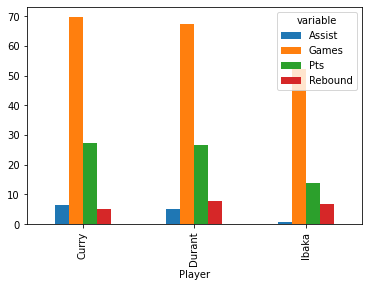

In [158]:
player_stats.unstack().plot.bar()

This particular visualization would be helpful if we wanted to see which stats
for which each player is strongest.

For example, we can see that Steph Curry scores far more points than he does
rebound, but Serge Ibaka is a bit more balanced.

What if we wanted to be able to compare all players for each statistic?

This would be easier to do if the bars were grouped by variable, with a
different bar for each player.

To plot this, we need to have the variables on the index and the player
name as column names.

We can get this DataFrame by setting `level="Player"` when calling `unstack`.

In [159]:
player_stats.unstack(level="Player")

Player,Curry,Durant,Ibaka
variable,,,
Assist,6.466667,5.066667,0.866667
Games,69.666667,67.333333,52.333333
Pts,27.266667,26.566667,13.966667
Rebound,5.000000,7.766667,6.800000


<AxesSubplot:xlabel='variable'>

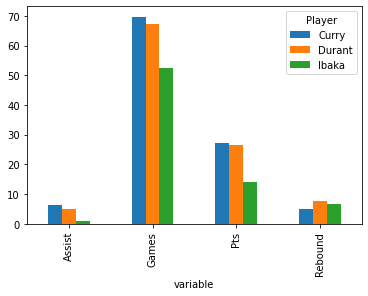

In [160]:
player_stats.unstack(level="Player").plot.bar()

Now we can use the chart to make a number of statements about players:

- Ibaka does not get many assists, compared to Curry and Durant.  
- Steph and Kevin Durant are both high scorers.  


Based on the examples above, notice a few things about `unstack`:

- It is the *inverse* of `stack`; `stack` will move labels down
  from columns to index, while `unstack` moves them up from index to columns.  
- By default, `unstack` will move the level of the index closest to the data
  and place it in the column labels closest to the data.  


>**Note**
>
>Just as we can pass multiple levels to `stack`, we can also pass multiple
levels to `unstack`.

We needed to use this in our solution to the exercise below.

Now we can use the chart to make a number of statements about players:

- Ibaka does not get many assists, compared to Curry and Durant.  
- Steph and Kevin Durant are both high scorers.  


Based on the examples above, notice a few things about `unstack`:

- It is the *inverse* of `stack`; `stack` will move labels down
  from columns to index, while `unstack` moves them up from index to columns.  
- By default, `unstack` will move the level of the index closest to the data
  and place it in the column labels closest to the data.  


>**Note**
>
>Just as we can pass multiple levels to `stack`, we can also pass multiple
levels to `unstack`.

We needed to use this in our solution to the exercise below.

### Summary

In some ways `set_index`, `reset_index`, `stack`, and `unstack`
are the “most fundamental” reshaping operations…

The other operations we discuss can be formulated with these
four operations (and, in fact, some of them are exactly written as these
operations in `pandas`’s code base).

*Pro tip*: We remember stack vs unstack with a mnemonic: **U**nstack moves index
levels **U**p

## `melt`

The `melt` method is used to move from wide to long form.

It can be used to move all of the “values” stored in your DataFrame to a
single column with all other columns being used to contain identifying
information.

When you use `melt`, any index that you currently have
will be deleted.

We saw used `melt` above when we constructed `bball_long`:

In [161]:
bball

,Year,Player,Team,TeamName,Games,Pts,Assist,Rebound
0,2015,Curry,GSW,Warriors,79,30.1,6.7,5.4
1,2016,Curry,GSW,Warriors,79,25.3,6.6,4.5
2,2017,Curry,GSW,Warriors,51,26.4,6.1,5.1
3,2015,Durant,OKC,Thunder,72,28.2,5.0,8.2
4,2016,Durant,GSW,Warriors,62,25.1,4.8,8.3
5,2017,Durant,GSW,Warriors,68,26.4,5.4,6.8
6,2015,Ibaka,OKC,Thunder,78,12.6,0.8,6.8
7,2016,Ibaka,ORL,Magic,56,15.1,1.1,6.8
8,2016,Ibaka,TOR,Raptors,23,14.2,0.7,6.8


In [163]:
# this is how we made ``bball_long``
bball.melt(id_vars=["Year", "Player", "Team", "TeamName"])

,Year,Player,Team,TeamName,variable,value
0,2015,Curry,GSW,Warriors,Games,79.0
1,2016,Curry,GSW,Warriors,Games,79.0
2,2017,Curry,GSW,Warriors,Games,51.0
3,2015,Durant,OKC,Thunder,Games,72.0
4,2016,Durant,GSW,Warriors,Games,62.0
5,2017,Durant,GSW,Warriors,Games,68.0
6,2015,Ibaka,OKC,Thunder,Games,78.0
7,2016,Ibaka,ORL,Magic,Games,56.0
8,2016,Ibaka,TOR,Raptors,Games,23.0
9,2015,Curry,GSW,Warriors,Pts,30.1


**Exercise 1**

Achieve:

`bball.melt(id_vars=["Year", "Player", "Team", "TeamName"])` 

using basic operations `set_index`, `reset_index`, `stack`, and `unstack`.

In [182]:
# bball.set_index(['Year', 'Player', 'Team', 'TeamName']).stack().reset_index().rename({'level_4': 'variable', 0: 'value'}, axis=1)

## `pivot` and `pivot_table`

The next two reshaping methods that we will use are closely related.

Some of you might even already be familiar with these ideas because you
have previously used *pivot tables* in Excel.

- If so, good news. We think this is even more powerful than Excel
  and easier to use!  
- If not, good news. You are about to learn a very powerful and user-friendly tool.  


We will begin with `pivot`.

The `pivot` method:

- Takes the unique values of one column and places them along the index.  
- Takes the unique values of another column and places them along the
  columns.  
- Takes the values that correspond to a third column and fills in the
  DataFrame values that correspond to that index/column pair.  


We’ll illustrate with an example.

In [187]:
bball.head(6)

,Year,Player,Team,TeamName,Games,Pts,Assist,Rebound
0,2015,Curry,GSW,Warriors,79,30.1,6.7,5.4
1,2016,Curry,GSW,Warriors,79,25.3,6.6,4.5
2,2017,Curry,GSW,Warriors,51,26.4,6.1,5.1
3,2015,Durant,OKC,Thunder,72,28.2,5.0,8.2
4,2016,Durant,GSW,Warriors,62,25.1,4.8,8.3
5,2017,Durant,GSW,Warriors,68,26.4,5.4,6.8


In [183]:
# .head 8 excludes Ibaka -- will discuss why later
bball.head(6).pivot(index="Year", columns="Player", values="Pts")

Player,Curry,Durant
Year,,
2015,30.1,28.2
2016,25.3,25.1
2017,26.4,26.4


We can replicate `pivot` using three of the fundamental operations
from above:

1. Call `set_index` with the `index` and `columns` arguments  
1. Extract the `values` column  
1. `unstack` the columns level of the new index  

In [165]:
#  1---------------------------------------  2---  3----------------------
bball.head(6).set_index(["Year", "Player"])["Pts"].unstack(level="Player")

Player,Curry,Durant
Year,,
2015,30.1,28.2
2016,25.3,25.1
2017,26.4,26.4


One important thing to be aware of is that in order for `pivot` to
work, the index/column pairs must be *unique*!

Below, we demonstrate the error that occurs when they are not unique.

In [190]:
bball

,Year,Player,Team,TeamName,Games,Pts,Assist,Rebound
0,2015,Curry,GSW,Warriors,79,30.1,6.7,5.4
1,2016,Curry,GSW,Warriors,79,25.3,6.6,4.5
2,2017,Curry,GSW,Warriors,51,26.4,6.1,5.1
3,2015,Durant,OKC,Thunder,72,28.2,5.0,8.2
4,2016,Durant,GSW,Warriors,62,25.1,4.8,8.3
5,2017,Durant,GSW,Warriors,68,26.4,5.4,6.8
6,2015,Ibaka,OKC,Thunder,78,12.6,0.8,6.8
7,2016,Ibaka,ORL,Magic,56,15.1,1.1,6.8
8,2016,Ibaka,TOR,Raptors,23,14.2,0.7,6.8


In [191]:
# Ibaka shows up twice in 2016 because he was traded mid-season from
# the Orlando Magic to the Toronto Raptors
# bball.pivot(index="Year", columns="Player", values="Pts")

In [ ]:
# how to fix?
# bball.pivot(index=['Year', 'Team'], columns='Player', values='Pts')

### `pivot_table`

The `pivot_table` method is a generalization of `pivot`.

It overcomes two limitations of `pivot`:

1. It allows you to choose multiple columns for the index/columns/values
  arguments.  
1. It allows you to deal with duplicate entries by
  having you choose how to combine them.  

In [192]:
bball

,Year,Player,Team,TeamName,Games,Pts,Assist,Rebound
0,2015,Curry,GSW,Warriors,79,30.1,6.7,5.4
1,2016,Curry,GSW,Warriors,79,25.3,6.6,4.5
2,2017,Curry,GSW,Warriors,51,26.4,6.1,5.1
3,2015,Durant,OKC,Thunder,72,28.2,5.0,8.2
4,2016,Durant,GSW,Warriors,62,25.1,4.8,8.3
5,2017,Durant,GSW,Warriors,68,26.4,5.4,6.8
6,2015,Ibaka,OKC,Thunder,78,12.6,0.8,6.8
7,2016,Ibaka,ORL,Magic,56,15.1,1.1,6.8
8,2016,Ibaka,TOR,Raptors,23,14.2,0.7,6.8


Notice that we can replicate the functionality of `pivot` if we pass
the same arguments.

In [193]:
bball.head(6).pivot(index="Year", columns="Player", values="Pts")

Player,Curry,Durant
Year,,
2015,30.1,28.2
2016,25.3,25.1
2017,26.4,26.4


But we can also choose multiple columns to be used in
index/columns/values.

In [194]:
bball.pivot_table(index=["Year", "Team"], columns="Player", values="Pts")

Player     Curry  Durant  Ibaka
Year Team                      
2015 GSW    30.1     NaN    NaN
     OKC     NaN    28.2   12.6
2016 GSW    25.3    25.1    NaN
     ORL     NaN     NaN   15.1
     TOR     NaN     NaN   14.2
2017 GSW    26.4    26.4    NaN

In [199]:
# bball.pivot(index=['Year', 'Team'], columns='Player', values='Pts')

In [197]:
bball.pivot_table(index="Year", columns=["Player", "Team"], values="Pts")

Player Curry Durant       Ibaka            
Team     GSW    GSW   OKC   OKC   ORL   TOR
Year                                       
2015    30.1    NaN  28.2  12.6   NaN   NaN
2016    25.3   25.1   NaN   NaN  15.1  14.2
2017    26.4   26.4   NaN   NaN   NaN   NaN

AND we can deal with duplicated index/column pairs.

In [200]:
# This produced an error
# bball.pivot(index="Year", columns="Player", values="Pts")

# This doesn't!
bball_pivoted = bball.pivot_table(index="Year", columns="Player", values="Pts")
bball_pivoted

Player,Curry,Durant,Ibaka
Year,,,
2015,30.1,28.2,12.60
2016,25.3,25.1,14.65
2017,26.4,26.4,NaN


`pivot_table` handles duplicate index/column pairs using an aggregation.

By default, the aggregation is the mean.

For example, our duplicated index/column pair is `("x", 1)` and had
associated values of 2 and 5.

Notice that `bball_pivoted.loc[2016, "Ibaka"]` is `(15.1 + 14.2)/2 = 14.65`.

We can choose how `pandas` aggregates all of the values.

For example, here’s how we would keep the max.

In [201]:
bball.pivot_table(index="Year", columns="Player", values="Pts", aggfunc=max)

Player,Curry,Durant,Ibaka
Year,,,
2015,30.1,28.2,12.6
2016,25.3,25.1,15.1
2017,26.4,26.4,NaN


Maybe we wanted to count how many values there were.

In [202]:
bball.pivot_table(index="Year", columns="Player", values="Pts", aggfunc=len)

Player,Curry,Durant,Ibaka
Year,,,
2015,1.0,1.0,1.0
2016,1.0,1.0,2.0
2017,1.0,1.0,NaN


We can even pass multiple aggregation functions!

In [203]:
bball.pivot_table(index="Year", columns="Player", values="Pts", aggfunc=[max, len])

max                len             
Player Curry Durant Ibaka Curry Durant Ibaka
Year                                        
2015    30.1   28.2  12.6   1.0    1.0   1.0
2016    25.3   25.1  15.1   1.0    1.0   2.0
2017    26.4   26.4   NaN   1.0    1.0   NaN

# Merge

**Prerequisites**

- [Reshape](https://datascience.quantecon.org/reshape.html)  


**Outcomes**

- Know the different pandas routines for combining datasets  
- Know when to use `pd.concat` vs `pd.merge` vs `pd.join`  
- Be able to apply the three main combining routines  


**Data**

- WDI data on GDP components, population, and square miles of countries  
- Book ratings: 6,000,000 ratings for the 10,000 most rated books on
  [Goodreads](https://www.goodreads.com/)  
- Details for all delayed US domestic flights in November 2016,
  obtained from the [Bureau of Transportation
  Statistics](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp)  

## Combining Datasets

Often, we will want perform joint analysis on data from different sources.

For example, when analyzing the regional sales for a company, we might
want to include industry aggregates or demographic information for each
region.

Or perhaps we are working with product-level data, have a list of
product groups in a separate dataset, and want to compute aggregate
statistics for each group.

In [204]:
# from WDI. Units trillions of 2010 USD (world development indicators)
url = "https://datascience.quantecon.org/assets/data/wdi_data.csv"
wdi = pd.read_csv(url).set_index(["country", "year"])
wdi.info()

wdi2017 = wdi.xs(2017, level="year")    # take year = 2017 data
wdi2017

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 72 entries, ('Canada', 2017) to ('United States', 2000)
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GovExpend    72 non-null     float64
 1   Consumption  72 non-null     float64
 2   Exports      72 non-null     float64
 3   Imports      72 non-null     float64
 4   GDP          72 non-null     float64
dtypes: float64(5)
memory usage: 3.9+ KB


,GovExpend,Consumption,Exports,Imports,GDP
country,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164
Germany,0.745579,2.112009,1.930563,1.666348,3.883870
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704
United States,2.405743,12.019266,2.287071,3.069954,17.348627


In [205]:
wdi2016_17 = wdi.loc[pd.IndexSlice[:, [2016, 2017]],: ]
wdi2016_17

,,GovExpend,Consumption,Exports,Imports,GDP
country,year,,,,,
Canada,2016,0.364899,1.058426,0.576394,0.575775,1.814016
Germany,2016,0.734014,2.075615,1.844949,1.589495,3.801859
United Kingdom,2016,0.550596,1.772348,0.816792,0.901494,2.768241
United States,2016,2.407981,11.722133,2.219937,2.936004,16.972348
Canada,2017,0.372665,1.095475,0.582831,0.600031,1.868164
Germany,2017,0.745579,2.112009,1.930563,1.666348,3.883870
United Kingdom,2017,0.549538,1.809154,0.862629,0.933145,2.818704
United States,2017,2.405743,12.019266,2.287071,3.069954,17.348627


In [206]:
# Data from https://www.nationmaster.com/country-info/stats/Geography/Land-area/Square-miles
# units -- millions of square miles
sq_miles = pd.Series({
   "United States": 3.8,
   "Canada": 3.8,
   "Germany": 0.137,
   "United Kingdom": 0.0936,
   "Russia": 6.6,
}, name="sq_miles").to_frame()
sq_miles.index.name = "country"
sq_miles

,sq_miles
country,
United States,3.8000
Canada,3.8000
Germany,0.1370
United Kingdom,0.0936
Russia,6.6000


In [207]:
# from WDI. Units millions of people
pop_url = "https://datascience.quantecon.org/assets/data/wdi_population.csv"
pop = pd.read_csv(pop_url).set_index(["country", "year"])
pop.info()
pop.head(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 72 entries, ('Canada', 2017) to ('United States', 2000)
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Population  72 non-null     float64
dtypes: float64(1)
memory usage: 1.7+ KB


Population
country year            
Canada  2017   36.540268
        2016   36.109487
        2015   35.702908
        2014   35.437435
        2013   35.082954
        2012   34.714222
        2011   34.339328
        2010   34.004889
        2009   33.628895
        2008   33.247118

Suppose that we were asked to compute a number of statistics with the data above:

- As a measure of land usage or productivity, what is Consumption per square mile?  
- What is GDP per capita (per person) for each country in each year? How about
  Consumption per person?  
- What is the population density of each country? How much does it change over time?  


Notice that to answer any of the questions from above, we will have to use data
from more than one of our DataFrames.

In this lecture, we will learn many techniques for combining datasets that
originate from different sources, careful to ensure that data is properly
aligned.

In pandas three main methods can combine datasets:

1. `pd.concat([dfs...])`  
1. `pd.merge(df1, df2)`  
1. `df1.join(df2)`  


We’ll look at each one.

## `pd.concat`

The `pd.concat` function is used to stack two or more DataFrames
together.

An example of when you might want to do this is if you have monthly data
in separate files on your computer and would like to have 1 year of data
in a single DataFrame.

The first argument to `pd.concat` is a list of DataFrames to be
stitched together.

The other commonly used argument is named `axis`.

As we have seen before, many pandas functions have an `axis` argument
that specifies whether a particular operation should happen down rows
(`axis=0`) or along columns (`axis=1`).

In the context of `pd.concat`, setting `axis=0` (the default case)
will stack DataFrames on top of one another while `axis=1` stacks them
side by side.

We’ll look at each case separately.

### `axis=0`

When we call `pd.concat` and set `axis=0`, the list of DataFrames
passed in the first argument will be stacked on top of one another.

Let’s try it out here.

In [208]:
# equivalent to pd.concat([wdi2017, sq_miles]) -- axis=0 is default
pd.concat([wdi2017, sq_miles], axis=0)

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,NaN
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,NaN
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,NaN
United States,2.405743,12.019266,2.287071,3.069954,17.348627,NaN
United States,NaN,NaN,NaN,NaN,NaN,3.8000
Canada,NaN,NaN,NaN,NaN,NaN,3.8000
Germany,NaN,NaN,NaN,NaN,NaN,0.1370
United Kingdom,NaN,NaN,NaN,NaN,NaN,0.0936
Russia,NaN,NaN,NaN,NaN,NaN,6.6000


Notice a few things:

The number of rows in the output is the total number
: of rows in all inputs. The labels are all from the original
DataFrames.

- The column labels are all the distinct column labels from all the inputs.  
- For columns that appeared only in one input, the value for all row labels
  originating from a different input is equal to `NaN` (marked as missing).  

### `axis=1`

In this example, concatenating by stacking
side-by-side makes more sense.

We accomplish this by passing `axis=1` to `pd.concat`:

In [209]:
pd.concat([wdi2017, sq_miles], axis=1)

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000
Russia,NaN,NaN,NaN,NaN,NaN,6.6000


Notice here that

- The index entries are all unique index entries that appeared in any DataFrame.  
- The column labels are all column labels from the inputs.  
- As `wdi2017` didn’t have a `Russia` row, the value for all of its columns
  is `NaN`.  


Now we can answer one of our questions from above: What is
Consumption per square mile?

In [210]:
temp = pd.concat([wdi2017, sq_miles], axis=1)
temp["Consumption"] / temp["sq_miles"]

country
Canada             0.288283
Germany           15.416124
United Kingdom    19.328569
United States      3.162965
Russia                  NaN
dtype: float64

## `pd.merge`

`pd.merge` operates on two DataFrames at a time and is primarily used
to bring columns from one DataFrame into another, *aligning* data based
on one or more “key” columns.

This is a somewhat difficult concept to grasp by reading, so let’s look at some
examples.

In [238]:
pd.merge(wdi2017, sq_miles, on="country")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


The output here looks very similar to what we saw with `concat` and
`axis=1`, except that the row for `Russia` does not appear.

We will talk more about why this happened soon.

For now, let’s look at a slightly more intriguing example:

In [212]:
pd.merge(wdi2016_17, sq_miles, on="country")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.364899,1.058426,0.576394,0.575775,1.814016,3.8000
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.734014,2.075615,1.844949,1.589495,3.801859,0.1370
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.550596,1.772348,0.816792,0.901494,2.768241,0.0936
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.407981,11.722133,2.219937,2.936004,16.972348,3.8000
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


Here’s how we think about what happened:

- The data in `wdi2016_17` is copied over exactly as is.  
- Because `country` was on the index for both DataFrames, it is on the
  index of the output.  
- We lost the year on the index – we’ll work on getting it back below.  
- The additional column in `sq_miles` was added to column labels for the
  output.  
- The data from the `sq_miles` column was added to the output by looking up
  rows where the `country` in the two DataFrames lined up.  
  - Note that all the countries appeared twice, and the data in `sq_miles` was repeated. This is because `wdi2016_17` had two rows for each country.  
  - Also note that because `Russia` did not appear in `wdi2016_17`, the value `sq_miles.loc["Russia"]` (i.e. `6.6`) is not used the output.  


How do we get the year back?

We must first call `reset_index` on `wdi2016_17` so
that in the first step when all columns are copied over, `year` is included.

In [213]:
pd.merge(wdi2016_17.reset_index(), sq_miles, on="country")

,country,year,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
0,Canada,2016,0.364899,1.058426,0.576394,0.575775,1.814016,3.8000
1,Canada,2017,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
2,Germany,2016,0.734014,2.075615,1.844949,1.589495,3.801859,0.1370
3,Germany,2017,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
4,United Kingdom,2016,0.550596,1.772348,0.816792,0.901494,2.768241,0.0936
5,United Kingdom,2017,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
6,United States,2016,2.407981,11.722133,2.219937,2.936004,16.972348,3.8000
7,United States,2017,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


### Multiple Columns

Sometimes, we need to merge multiple columns.

For example our `pop` and `wdi2016_17` DataFrames both have observations
organized by country and year.

To properly merge these datasets, we would need to align the data by
both country and year.

We pass a list to the `on` argument to accomplish this:

In [214]:
pd.merge(wdi2016_17, pop, on=["country", "year"])

,,GovExpend,Consumption,Exports,Imports,GDP,Population
country,year,,,,,,
Canada,2016,0.364899,1.058426,0.576394,0.575775,1.814016,36.109487
Germany,2016,0.734014,2.075615,1.844949,1.589495,3.801859,82.348669
United Kingdom,2016,0.550596,1.772348,0.816792,0.901494,2.768241,65.595565
United States,2016,2.407981,11.722133,2.219937,2.936004,16.972348,323.071342
Canada,2017,0.372665,1.095475,0.582831,0.600031,1.868164,36.540268
Germany,2017,0.745579,2.112009,1.930563,1.666348,3.883870,82.657002
United Kingdom,2017,0.549538,1.809154,0.862629,0.933145,2.818704,66.058859
United States,2017,2.405743,12.019266,2.287071,3.069954,17.348627,325.147121


Now, we can answer more of our questions from above: What is GDP per capita (per
person) for each country in each year? How about Consumption per person?

In [215]:
wdi_pop = pd.merge(wdi2016_17, pop, on=["country", "year"])
wdi_pop["GDP"] / wdi_pop["Population"]

country         year
Canada          2016    0.050237
Germany         2016    0.046168
United Kingdom  2016    0.042202
United States   2016    0.052534
Canada          2017    0.051126
Germany         2017    0.046988
United Kingdom  2017    0.042670
United States   2017    0.053356
dtype: float64

In [216]:
wdi_pop["Consumption"] / wdi_pop["Population"]

country         year
Canada          2016    0.029312
Germany         2016    0.025205
United Kingdom  2016    0.027019
United States   2016    0.036283
Canada          2017    0.029980
Germany         2017    0.025551
United Kingdom  2017    0.027387
United States   2017    0.036966
dtype: float64

## Arguments to `merge`

The `pd.merge` function can take many optional arguments.

We’ll talk about a few of the most commonly-used ones here and refer you
to the
[documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.merge.html#pandas.merge)
for more details.

We’ll follow the pandas convention and refer to the first argument to
`pd.merge` as `left` and call the second `right`.

### `on`

We have already seen this one used before, but we want to point out that on
is optional.

If nothing is given for this argument, pandas will use **all** columns
in `left` and `right` with the same name.

In our example, `country` is the only column that appears in both
DataFrames, so it is used for `on` if we don’t pass anything.

The following two are equivalent.

In [249]:
pd.merge(wdi2017, sq_miles, on="country")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


In [245]:
wdi2017.reset_index()

,country,GovExpend,Consumption,Exports,Imports,GDP
0,Canada,0.372665,1.095475,0.582831,0.600031,1.868164
1,Germany,0.745579,2.112009,1.930563,1.666348,3.883870
2,United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704
3,United States,2.405743,12.019266,2.287071,3.069954,17.348627


In [246]:
sq_miles.reset_index()

,country,sq_miles
0,United States,3.8000
1,Canada,3.8000
2,Germany,0.1370
3,United Kingdom,0.0936
4,Russia,6.6000


In [250]:
# if we move index back to columns, the `on` is un-necessary
# automatically chooses the intersection of the columns in both dataframes
pd.merge(wdi2017.reset_index(), sq_miles.reset_index())

,country,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
0,Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
1,Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
2,United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
3,United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


### `left_on`, `right_on`

Above, we used the `on` argument to identify a column in both `left`
and `right` that was used to align data.

Sometimes, both DataFrames don’t have the same name for this column.

In that case, we use the `left_on` and `right_on` arguments, passing
the proper column name(s) to align the data.

We’ll show you an example below, but it is somewhat silly as our
DataFrames do both have the `country` column.

In [219]:
pd.merge(wdi2017, sq_miles, left_on="country", right_on="country")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


### `left_index`, `right_index`

Sometimes, as in our example, the key used to align data is actually in the
index instead of one of the columns.

In this case, we can use the `left_index` or `right_index` arguments.

We should only set these values to a boolean (`True` or `False`).

Let’s practice with this.

In [220]:
pd.merge(wdi2017, sq_miles, left_on="country", right_index=True)

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


### `how`

The `how` is perhaps the most powerful, but most conceptually
difficult of the arguments we will cover.

This argument controls which values from the key column(s) appear in the
output.

The 4 possible options for this argument are summarized in
the image below.

![https://datascience.quantecon.org/_static/merge_venns.png](https://datascience.quantecon.org/_static/merge_venns.png)

  
In words, we have:

- `left`: Default and what we described above. It uses
  the keys from the `left` DataFrame.  
- `right`: Output will contain all keys from `right`.  
- `inner`: The output will only contain keys that appear in *both*
  `left` and `right`.  
- `outer`: The output will contain any key found in either `left`
  or `right`.  


In addition to the above, we will use the following two DataFrames to
illustrate the `how` option.

In [221]:
wdi2017_no_US = wdi2017.drop("United States")
wdi2017_no_US

,GovExpend,Consumption,Exports,Imports,GDP
country,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164
Germany,0.745579,2.112009,1.930563,1.666348,3.883870
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704


In [222]:
sq_miles_no_germany = sq_miles.drop("Germany")
sq_miles_no_germany

,sq_miles
country,
United States,3.8000
Canada,3.8000
United Kingdom,0.0936
Russia,6.6000


Now, let’s see all the possible `how` options.

In [223]:
# default
pd.merge(wdi2017, sq_miles, on="country", how="left")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


In [224]:
# notice ``Russia`` is included
pd.merge(wdi2017, sq_miles, on="country", how="right")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
Russia,NaN,NaN,NaN,NaN,NaN,6.6000


In [225]:
# notice no United States or Russia
pd.merge(wdi2017_no_US, sq_miles, on="country", how="inner")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936


In [226]:
# includes all 5, even though they don't all appear in either DataFrame
pd.merge(wdi2017_no_US, sq_miles_no_germany, on="country", how="outer")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,NaN
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,NaN,NaN,NaN,NaN,NaN,3.8000
Russia,NaN,NaN,NaN,NaN,NaN,6.6000


### `df.merge(df2)`

Note that the DataFrame type has a `merge` *method*.

It is the same as the function we have been working with, but passes the
DataFrame before the period as `left`.

Thus `df.merge(other)` is equivalent to `pd.merge(df, other)`.

In [227]:
wdi2017.merge(sq_miles, on="country", how="right")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
Russia,NaN,NaN,NaN,NaN,NaN,6.6000


## `df.join`

The `join` method for a DataFrame is very similar to the `merge`
method described above, but only allows you to use the index of the
`right` DataFrame as the join key.

Thus, `left.join(right, on="country")` is equivalent to calling
`pd.merge(left, right, left_on="country", right_index=True)`.

The implementation of the `join` method calls `merge` internally,
but sets the `left_on` and `right_index` arguments for you.

You can do anything with `df.join` that you can do with
`df.merge`, but df.join`is more convenient to use if the keys of`right`
are in the index.

In [257]:
wdi2017.join(sq_miles, on="country")

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


In [229]:
wdi2017.merge(sq_miles, left_on="country", right_index=True)

,GovExpend,Consumption,Exports,Imports,GDP,sq_miles
country,,,,,,
Canada,0.372665,1.095475,0.582831,0.600031,1.868164,3.8000
Germany,0.745579,2.112009,1.930563,1.666348,3.883870,0.1370
United Kingdom,0.549538,1.809154,0.862629,0.933145,2.818704,0.0936
United States,2.405743,12.019266,2.287071,3.069954,17.348627,3.8000


# GroupBy

**Prerequisites**

- [Functions](https://datascience.quantecon.org/../python_fundamentals/functions.html)  
- pandas introduction [1](https://datascience.quantecon.org/intro.html) and [2](https://datascience.quantecon.org/basics.html)  
- [Reshape](https://datascience.quantecon.org/reshape.html)  


**Outcomes**

- Understand the split-apply-combine strategy for aggregate
  computations on groups of data  
- Be able use basic aggregation methods on `df.groupby` to compute
  within group statistics  
- Understand how to group by multiple keys at once  


**Data**

- Details for all delayed US domestic flights in December 2016,
  obtained from the [Bureau of Transportation
  Statistics](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp)  

## Split-Apply-Combine

One powerful paradigm for analyzing data is the “Split-Apply-Combine”
strategy.

This strategy has three steps:

1. `Split`: split the data into groups based on values in one or more columns.  
1. `Apply`: apply a function or routine to each group separately.  
1. `Combine`: combine the output of the apply step into a DataFrame,
  using the group identifiers as the index.  


We will cover the main components in this lecture, but we encourage you
to also study the [official
documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html)
to learn more about what is possible.

To describe the concepts, we will need some data.

We will begin with a simple made-up dataset to discuss the concepts and
then work through extended example and exercises with real data.

In [258]:
C = np.arange(1, 7, dtype=float)
C[[3, 5]] = np.nan
df = pd.DataFrame({
    "A" : [1, 1, 1, 2, 2, 2],
    "B" : [1, 1, 2, 2, 1, 1],
    "C": C,
})
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


### Simple Example

To perform the *Split* step, we call the `groupby` method on our
DataFrame.

The first argument to `groupby` is a description of how we want to
construct groups.

In the most basic version, we will pass a string identifying the column
name.

In [259]:
gbA = df.groupby("A")

The `type` of variable we get back is a `DataFrameGroupBy`, which we
will sometimes refer to as GroupBy for short.

In [260]:
type(gbA)

pandas.core.groupby.generic.DataFrameGroupBy

Looking at the “groups” inside of the GroupBy object can help us
understand what the GroupBy represents.

We can do this with the `gb.get_group(group_name)` method.

In [261]:
gbA.get_group(1)

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0


In [262]:
gbA.get_group(2)

,A,B,C
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


We can *apply* some of our favorite aggregation functions directly on the
`GroupBy` object.

If we pass a list of strings to `groupby`, it will group based on
unique combinations of values from all columns in the list.

Let’s see an example.

In [263]:
gbAB = df.groupby(["A", "B"])
type(gbAB)

pandas.core.groupby.generic.DataFrameGroupBy

In [264]:
gbAB.get_group((1, 1))

,A,B,C
0,1,1,1.0
1,1,1,2.0


Notice that we still have a GroupBy object, so we can apply our favorite
aggregations.

In [265]:
gbAB.count()

C
A B   
1 1  2
  2  1
2 1  1
  2  0

Notice that the output is a DataFrame with two levels on the index
and a single column `C`. (Quiz: how do we know it is a DataFrame with
one column and not a Series?)

This highlights a principle of how pandas handles the *Combine* part of
the strategy:

> The index of the combined DataFrame will be the group identifiers,
with one index level per group key.

### Custom Aggregate Functions

So far, we have been applying built-in aggregations to our GroupBy object.

We can also apply custom aggregations to each group of a GroupBy in two
steps:

1. Write our custom aggregation as a Python function.  
1. Passing our function as an argument to the `.agg` method of a GroupBy.  


Let’s see an example.

In [266]:
def num_missing(df):
    "Return the number of missing items in each column of df"
    return df.isnull().sum()

We can call this function on our original DataFrame to get the number of
missing items in each column.

In [267]:
num_missing(df)

A    0
B    0
C    2
dtype: int64

We can also apply it to a GroupBy object to get the number of missing
items in each column *for each group*.

In [268]:
gbA.agg(num_missing)

,B,C
A,,
1,0,0
2,0,2


The key to keep in mind is that the function we pass to `agg` should
take in a DataFrame (or Series) and return a Series (or single value)
with one item per column in the original DataFrame.

When the function is called, the data for each group will be passed to
our function as a DataFrame (or Series).

### Transforms: The `apply` Method

As we saw in the [basics lecture](https://datascience.quantecon.org/basics.html), we can apply transforms to DataFrames.

We can do the same with GroupBy objects using the `.apply` method.

Let’s see an example.

In [281]:
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


In [270]:
def smallest_by_b(df):
    return df.nsmallest(2, "B")

In [271]:
gbA.apply(smallest_by_b)

A  B    C
A             
1 0  1  1  1.0
  1  1  1  2.0
2 4  2  1  5.0
  5  2  1  NaN

Notice that the return value from applying our series transform to `gbA`
was the group key on the outer level (the `A` column) and the original
index from `df` on the inner level.

The original index came along because that was the index of the
DataFrame returned by `smallest_by_b`.

Had our function returned something other than the index from `df`,
that would appear in the result of the call to `.apply`.

### `pd.Grouper`

Sometimes, in order to construct the groups you want, you need to give
pandas more information than just a column name.

Some examples are:

- Grouping by a column and a level of the index.  
- Grouping time series data at a particular frequency.  


pandas lets you do this through the `pd.Grouper` type.

To see it in action, let’s make a copy of `df` with `A` moved to the
index and a `Date` column added.

In [291]:
df2 = df.copy()
df2["Date"] = pd.date_range(
    start=dt.date.today().strftime("%m/%d/%Y"),
    freq="BQ",  # business quarter end
    periods=df.shape[0]
)
df2 = df2.set_index("A")
df2

,B,C,Date
A,,,
1,1,1.0,2022-09-30
1,1,2.0,2022-12-30
1,2,3.0,2023-03-31
2,2,NaN,2023-06-30
2,1,5.0,2023-09-29
2,1,NaN,2023-12-29


We can group by year.

In [273]:
df2.groupby(pd.Grouper(key="Date", freq="A")).count()

,B,C
Date,,
2022-12-31,2,2
2023-12-31,4,2


We can group by the `A` level of the index.

In [274]:
df2.groupby(pd.Grouper(level="A")).count()

,B,C,Date
A,,,
1,3,3,3
2,3,1,3


We can combine these to group by both.

In [275]:
df2.groupby([pd.Grouper(key="Date", freq="A"), pd.Grouper(level="A")]).count()

B  C
Date       A      
2022-12-31 1  2  2
2023-12-31 1  1  1
           2  3  1

And we can combine `pd.Grouper` with a string, where the string
denotes a column name

In [276]:
df2.groupby([pd.Grouper(key="Date", freq="A"), "B"]).count()

C
Date       B   
2022-12-31 1  2
2023-12-31 1  1
           2  1

## Case Study: Airline Delays

Let’s apply our new split-apply-combine skills to the airline dataset we
saw in the [merge](https://datascience.quantecon.org/merge.html) lecture.

In [292]:
url = "https://datascience.quantecon.org/assets/data/airline_performance_dec16.csv.zip"
air_dec = pd.read_csv(url, parse_dates = ['Date'])

First, we compute the average delay in arrival time for all carriers
each week.

In [293]:
weekly_delays = (
    air_dec
    .groupby([pd.Grouper(key="Date", freq="W"), "Carrier"])
    ["ArrDelay"]               # extract one column
    .mean()                    # take average
    .unstack(level="Carrier")  # Flip carrier up as column names
)
weekly_delays

Carrier,AA,AS,B6,DL,EV,F9,HA,NK,OO,UA,VX,WN
Date,,,,,,,,,,,,
2016-12-04,-1.714887,2.724273,-2.894269,-5.088351,8.655332,-2.894212,-0.558282,5.468909,2.749573,5.564496,-2.121821,-1.663695
2016-12-11,1.148833,12.052031,5.795062,2.507745,13.220673,4.578861,2.054302,8.713755,15.429660,4.094176,12.080938,1.865933
2016-12-18,16.357561,7.643767,34.608356,18.000000,23.876622,45.014888,9.388889,22.857899,30.901639,22.398130,33.651128,18.373400
2016-12-25,6.364513,2.719699,5.586836,-0.916113,6.857143,54.084959,5.075747,10.443369,15.004780,5.332474,17.286917,10.197685
2017-01-01,2.321836,1.226662,10.661577,2.048116,6.800898,8.280298,6.970016,8.361123,8.971083,0.061786,1.349580,5.213019


More in the original lecture on `groupby`.